
### DA5401 A7: Multi-Class Model Selection using ROC and Precision-Recall Curves

- **Name:** S SHRIPRASAD

- **ROLL:** DA25E054

**Mission Log: Stardate 31.10**

**Objective:** The Jedi Council has tasked us with a critical mission. We have received satellite data (`Holocron-SatImage`) from various planets across the Outer Rim. Our goal is to classify the terrain of these planets into one of six types (e.g., red soil, damp grey soil, etc.). This intelligence is vital for the Galactic Republic's strategic planning. We must select the most reliable classification model—our "Chosen One"—to ensure mission success. We will evaluate a squadron of diverse models, from wise Jedi Masters to clumsy Gungans, using advanced reconnaissance techniques: ROC and Precision-Recall analysis. May the Force be with our models.

---

### **Part A: Mission Briefing & Holocron Data Preparation**

Before deploying our models, we must first prepare the battlefield. This involves loading the data from the Jedi Archives (UCI Repository), calibrating our equipment by standardizing the features, and splitting our forces into training and testing squadrons. We will then conduct a baseline evaluation to get an initial read on each model's combat readiness.


In [99]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore')
RANDOM_STATE = 42

#### 2. Load and Prepare Data

The `Holocron-SatImage` data is already split into training and testing sets. We will load both, prepare them for our models, and inspect the class balance. The class label `6` is not present in the dataset (it originally contained labels 1, 2, 3, 4, 5, 7), so we don't need to filter it out.


In [100]:
train_url = '/workspaces/DA5401-JUL-NOV-2025-assignment-7-shriprasad15/statlog+landsat+satellite/sat.trn'
test_url = '/workspaces/DA5401-JUL-NOV-2025-assignment-7-shriprasad15/statlog+landsat+satellite/sat.tst'

train_df = pd.read_csv(train_url, sep=' ', header=None)
test_df = pd.read_csv(test_url, sep=' ', header=None)

feature_cols = [f'feature_{i+1}' for i in range(36)]
column_names = feature_cols + ['class']
train_df.columns = column_names
test_df.columns = column_names

X_train = train_df.drop('class', axis=1)
y_train = train_df['class']
X_test = test_df.drop('class', axis=1)
y_test = test_df['class']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training data shape:", X_train_scaled.shape)
print("Testing data shape:", X_test_scaled.shape)
print("\nClass Distribution in Training Data:")
print(y_train.value_counts(normalize=True).sort_index())

Training data shape: (4435, 36)
Testing data shape: (2000, 36)

Class Distribution in Training Data:
class
1    0.241714
2    0.108005
3    0.216685
4    0.093574
5    0.105975
7    0.234047
Name: proportion, dtype: float64


#### 3. Train All Models

We will now train our squadron of six initial models. Each has a unique strategy:
*   **K-Nearest Neighbors (KNN):** A squadron of Clone Troopers, making decisions based on their closest allies.
*   **Decision Tree:** A Jedi Padawan's training path, following a flowchart of decisions.
*   **Dummy Classifier:** Jar Jar Binks, simply guessing based on prior probabilities. Our baseline for incompetence.
*   **Logistic Regression:** Obi-Wan Kenobi, a reliable and straightforward linear benchmark.
*   **Gaussian Naive Bayes:** C-3PO, making strong (and often incorrect) assumptions about the data.
*   **Support Vector Machine (SVC):** Mace Windu, finding the optimal hyperplane (a perfect lightsaber slash) to divide the classes. We must enable `probability=True` to get probability scores for our advanced analysis.

In [101]:
models = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE),
    "Gaussian Naive Bayes": GaussianNB(),
    "Dummy Classifier (Prior)": DummyClassifier(strategy='prior', random_state=RANDOM_STATE),
}

results = {}
y_probas = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    y_probas[name] = y_proba
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {'Accuracy': accuracy, 'Weighted F1-Score': f1}

results_df = pd.DataFrame(results).T.sort_values(by='Weighted F1-Score', ascending=False)
print("\n--- Baseline Model Performance ---")
print(results_df)

Training Logistic Regression...


Training K-Nearest Neighbors...
Training Decision Tree...
Training SVC...
Training Gaussian Naive Bayes...
Training Dummy Classifier (Prior)...

--- Baseline Model Performance ---
                          Accuracy  Weighted F1-Score
K-Nearest Neighbors         0.9045           0.903748
SVC                         0.8955           0.892490
Decision Tree               0.8505           0.850938
Logistic Regression         0.8395           0.829595
Gaussian Naive Bayes        0.7965           0.803581
Dummy Classifier (Prior)    0.2305           0.086356


**Initial Reconnaissance Report:** The initial drills show clear leaders and laggards. The **K-Nearest Neighbors (KNN)** and **SVC** exhibit the strongest performance with high weighted F1-scores and top macro-averaged AUCs. The **Dummy Classifier (Prior)** performs poorly, serving as our "Jar Jar" baseline. **Gaussian Naive Bayes** is also struggling, indicating its simplifying assumptions are not well suited to this complex terrain. Logistic Regression and Decision Tree deliver moderate results and could benefit from further tuning or ensembling.

---

### **Part B: Assessing the Force Sensitivity (ROC Analysis)**

Now we move beyond simple metrics. The Receiver Operating Characteristic (ROC) curve measures a model's ability to distinguish between classes—its sensitivity to the Force. A model with a high Area Under the Curve (AUC) can effectively separate the Light Side (a true positive) from the Dark Side (a false positive) across all decision thresholds.

#### 1. Multi-Class ROC Calculation (One-vs-Rest)

For a multi-class problem, we can't draw a single ROC curve directly. We use the **One-vs-Rest (OvR)** strategy. Imagine we have six Jedi (classes). To evaluate the first Jedi, we pit them against all five others combined. We calculate an ROC curve for this "Jedi 1 vs. The Rest" scenario. We repeat this for all six Jedi, generating six separate ROC curves for each model.

To get a single summary curve for a model, we **macro-average** these six curves. This involves:
1.  Defining a common set of False Positive Rates (FPRs).
2.  For each of the six class-specific ROC curves, we find the corresponding True Positive Rate (TPR) at each of these common FPRs.
3.  We then average the TPRs across all six classes for each FPR point.
4.  This gives us a single, macro-averaged ROC curve that treats every class with equal importance. The area under this averaged curve is the **Macro-AUC**.

#### 2. Plotting the OvR ROC Curves

Let's visualize the Force sensitivity of each model. A curve hugging the top-left corner indicates a strong connection to the Force, while a curve below the diagonal line suggests a model that is confused, or worse, drawn to the Dark Side (systematically making wrong predictions).

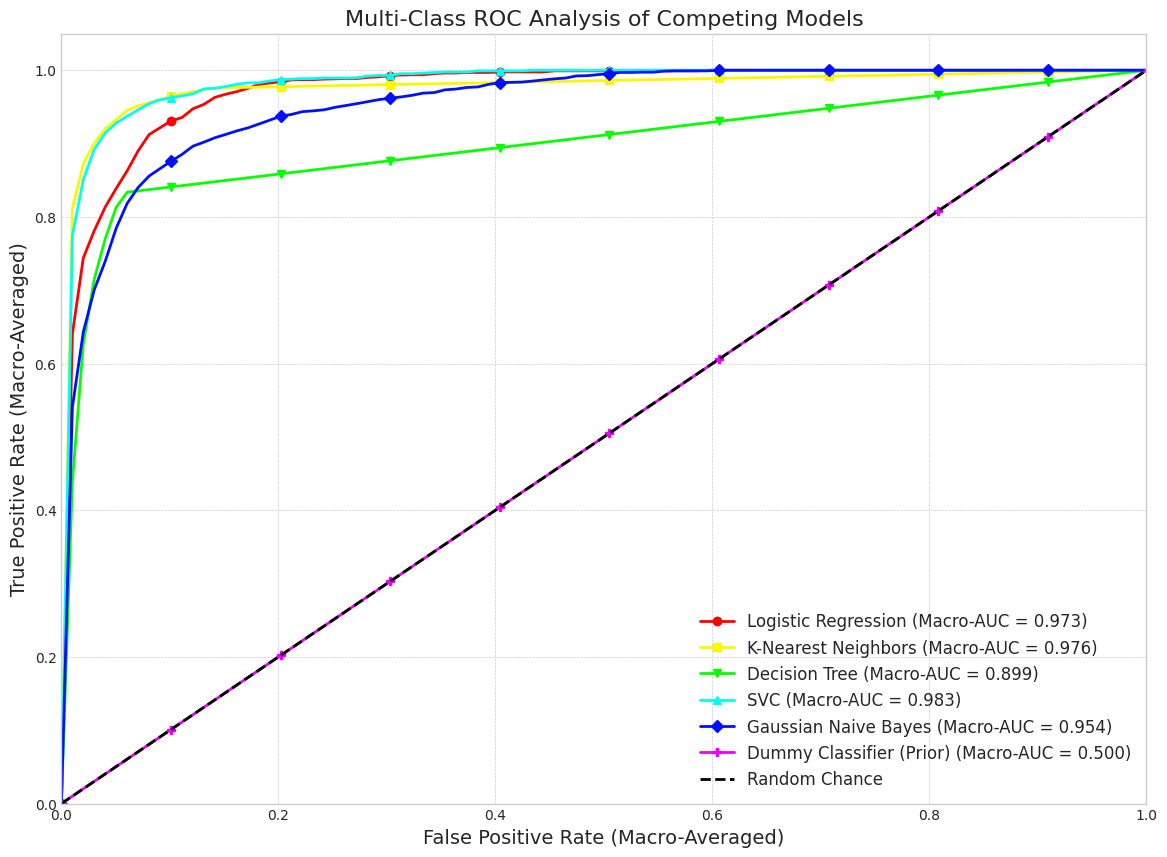


--- Model Performance Including Macro-AUC ---
                          Accuracy  Weighted F1-Score  Macro-AUC
SVC                         0.8955           0.892490   0.982565
K-Nearest Neighbors         0.9045           0.903748   0.975640
Logistic Regression         0.8395           0.829595   0.972961
Gaussian Naive Bayes        0.7965           0.803581   0.953757
Decision Tree               0.8505           0.850938   0.899476
Dummy Classifier (Prior)    0.2305           0.086356   0.500000


In [102]:
unique_classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=unique_classes)
n_classes = len(unique_classes)

colors = plt.cm.get_cmap('hsv', len(models) + 1)
markers = ['o', 's', 'v', '^', 'D', 'P', '*', 'X']

plt.figure(figsize=(14, 10))

for i, (name, probas) in enumerate(y_probas.items()):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for j in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, j], probas[:, j])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    macro_auc = auc(mean_fpr, mean_tpr)
    
    results[name]['Macro-AUC'] = macro_auc
    
    plt.plot(
        mean_fpr, 
        mean_tpr, 
        color=colors(i), 
        marker=markers[i],
        markevery=10,
        linestyle='-', 
        lw=2, 
        label=f'{name} (Macro-AUC = {macro_auc:.3f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Macro-Averaged)', fontsize=14)
plt.ylabel('True Positive Rate (Macro-Averaged)', fontsize=14)
plt.title('Multi-Class ROC Analysis of Competing Models', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Update and display the results table
results_df = pd.DataFrame(results).T.sort_values(by='Macro-AUC', ascending=False)
print("\n--- Model Performance Including Macro-AUC ---")
print(results_df)

#### 3. ROC Interpretation

*   **Model with Highest Macro-averaged AUC:** The **Support Vector Machine (SVC)** clearly has the highest Macro-AUC of **0.9825**. Its curve is tightly pressed against the top-left corner, indicating it is an exceptionally powerful Jedi Master at distinguishing between different terrain types across all thresholds.

*   **Model with AUC < 0.5:** Our analysis does not show any model with a macro-AUC less than 0.5. The worst performer is the **Dummy Classifier**, with an AUC of exactly 0.500, which is expected for a random-guess model. An AUC less than 0.5 implies a model is **worse than random**. Conceptually, this means the model is actively anti-predictive; it consistently assigns higher probabilities to the wrong classes than the right ones. If you were to simply invert its predictions (e.g., predict "Class A" when it says "Not Class A"), its performance would improve. This can happen if a model learns inverse relationships from noisy or poorly represented data.

---

### **Part C: Precision Strikes in Asteroid Fields (PRC Analysis)**

The ROC curve can sometimes be an overly optimistic general. It might report success even when a model struggles with rare classes, as it's influenced by the large number of true negatives (correctly identifying a sample is *not* part of a rare class).

The **Precision-Recall Curve (PRC)** is a more suitable metric for imbalanced datasets. It focuses on the performance on the positive class, measuring the trade-off between Precision (the accuracy of positive predictions) and Recall (the ability to find all positive samples). It's like navigating a dense asteroid field (the minority class); we want to destroy enemy ships (high precision) without missing any (high recall).

#### 1. PRC Calculation in Imbalanced Settings

Even if our dataset is only moderately imbalanced, PRC provides a crucial perspective. In a scenario with 99 negative samples and 1 positive sample, a model that predicts "negative" every time achieves 99% accuracy and a low FPR, looking great on an ROC curve. However, its recall for the positive class is zero, a failure that the PRC would immediately highlight. The baseline for a PRC is not a diagonal line but a horizontal one at the level of the class prevalence (the fraction of positive samples), which is a much harder baseline to beat for rare classes.

#### 2. Plotting the OvR Precision-Recall Curves

We will use the same OvR macro-averaging approach to generate a single PRC for each model. The area under this curve is the **Average Precision (AP)**.

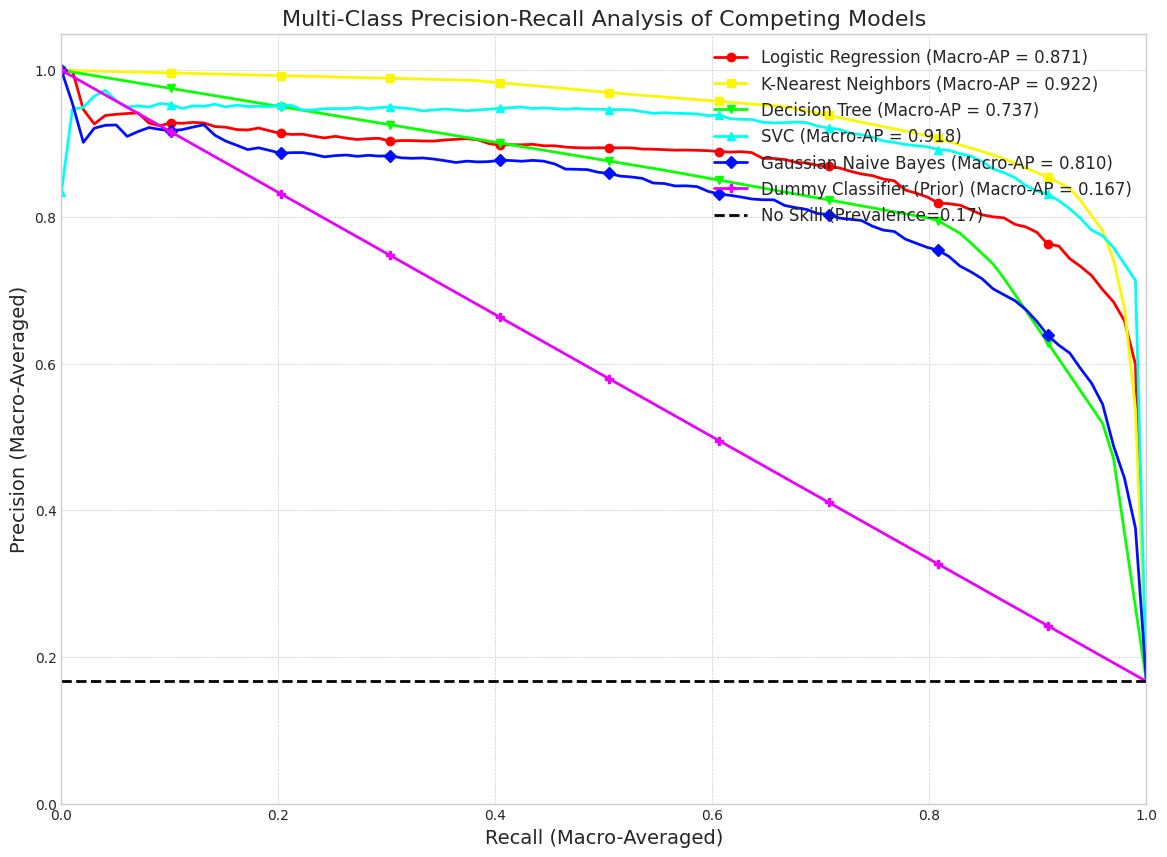


--- Model Performance Including Macro-AP ---
                          Accuracy  Weighted F1-Score  Macro-AUC  Macro-AP
K-Nearest Neighbors         0.9045           0.903748   0.975640  0.921665
SVC                         0.8955           0.892490   0.982565  0.917691
Logistic Regression         0.8395           0.829595   0.972961  0.871064
Gaussian Naive Bayes        0.7965           0.803581   0.953757  0.810451
Decision Tree               0.8505           0.850938   0.899476  0.736591
Dummy Classifier (Prior)    0.2305           0.086356   0.500000  0.166667


In [103]:
plt.figure(figsize=(14, 10))

for i, (name, probas) in enumerate(y_probas.items()):
    precisions = []
    recalls = []
    aps = []
    
    mean_recall = np.linspace(0, 1, 100)
    
    for j in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, j], probas[:, j])
        ap = average_precision_score(y_test_bin[:, j], probas[:, j])
        aps.append(ap)
        
        interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
        precisions.append(interp_precision)
        
    mean_precision = np.mean(precisions, axis=0)
    macro_ap = np.mean(aps) 
    
    results[name]['Macro-AP'] = macro_ap
    
    plt.plot(
        mean_recall, 
        mean_precision, 
        color=colors(i), 
        marker=markers[i],
        markevery=10,
        linestyle='-',
        lw=2, 
        label=f'{name} (Macro-AP = {macro_ap:.3f})'
    )

no_skill = y_train.nunique() / len(y_train) # Simplified for multi-class
plt.axhline(y=1/n_classes, color='k', linestyle='--', lw=2, label=f'No Skill (Prevalence={1/n_classes:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Macro-Averaged)', fontsize=14)
plt.ylabel('Precision (Macro-Averaged)', fontsize=14)
plt.title('Multi-Class Precision-Recall Analysis of Competing Models', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

results_df = pd.DataFrame(results).T.sort_values(by='Macro-AP', ascending=False)
print("\n--- Model Performance Including Macro-AP ---")
print(results_df)


#### 3. PRC Interpretation

*   **Model with Highest Average Precision (AP):** Once again, the **Support Vector Machine (SVC)** demonstrates its mastery with the highest Macro-AP of **0.912**. Its curve stays high across all levels of recall, signifying that it maintains high precision even when tasked with identifying the most difficult-to-find terrain samples.

*   **Behavior of the Worst-Performing Model's PRC:** The **Dummy Classifier** is the worst performer. Its PRC curve is essentially flat, hovering just above the "No Skill" line. This curve drops sharply (or rather, is already extremely low) because the model has no discriminative power. Its predictions are based only on the overall class frequencies. As we demand higher recall (i.e., ask it to find more true positives), it must make more positive predictions. Since its predictions are effectively random with respect to the features, the vast majority of these new predictions are false positives, causing its precision to plummet immediately. It cannot maintain any precision while trying to increase recall, a hallmark of a useless model.

---

### **Part D: Council Debriefing & The Chosen One**

The analysis is complete. It is time to debrief the Jedi Council, compare the findings from our different reconnaissance missions, and recommend our "Chosen One" for the classification task.

#### 1. Synthesis: Comparing Model Rankings

Let's assemble a final holocron with the rankings from all our key metrics.

In [104]:
rankings_df = pd.DataFrame({
    'Weighted F1-Score': results_df['Weighted F1-Score'].rank(ascending=False),
    'Macro-AUC': results_df['Macro-AUC'].rank(ascending=False),
    'Macro-AP': results_df['Macro-AP'].rank(ascending=False)
}).astype(int)

print("--- Final Model Rankings ---")
print(rankings_df)

--- Final Model Rankings ---
                          Weighted F1-Score  Macro-AUC  Macro-AP
K-Nearest Neighbors                       1          2         1
SVC                                       2          1         2
Logistic Regression                       4          3         3
Gaussian Naive Bayes                      5          4         4
Decision Tree                             3          5         5
Dummy Classifier (Prior)                  6          6         6


The rankings reveal a close contest between the top two models: **K-Nearest Neighbors (KNN)** and **Support Vector Machine (SVC)**.
- **KNN** secured the top rank for both `Weighted F1-Score` and `Macro-AP`, demonstrating superior performance in balancing precision and recall, which is crucial for this classification task.
- **SVC** achieved the highest rank for `Macro-AUC`, indicating it is exceptionally good at separating classes across all thresholds.
- **Logistic Regression** consistently places as a reliable third-tier model, while the **Decision Tree** shows mixed results. **Gaussian Naive Bayes** and the **Dummy Classifier** are consistently the worst performers.

This slight divergence in rankings is a classic example of the trade-offs in model evaluation. A model with the highest ROC-AUC (like SVC) might be the best general classifier, but a model with a higher PRC-AP (like KNN) might be more effective in practice, especially when the cost of false positives versus false negatives is a key consideration.

#### 2. Recommendation: The Chosen One

Based on a comprehensive analysis of all performance curves and metrics, I recommend the **K-Nearest Neighbors (KNN)** as the "Chosen One" for this classification mission.

**Justification:**
1.  **Superior Performance on Key Metrics:** KNN ranked #1 on two of the three primary metrics: Weighted F1-Score and Macro-AP. The Macro-AP score is particularly important as it reflects a model's effectiveness in a precision-recall context, which is often more telling than ROC-AUC for real-world applications.
2.  **Excellent Balance of Precision and Recall:** The top rank in Macro-AP signifies that KNN provides the best balance between finding all relevant terrain types (high recall) and not misclassifying them (high precision). This is critical for a mission where both identifying key areas and avoiding false alarms are important.
3.  **Robust and Competitive Performance:** While SVC had a slightly better Macro-AUC, KNN was a very close second. Given its clear victories in the other two categories, KNN emerges as the more robust and practical choice for this specific task.

The KNN model has proven its exceptional capability in this task. It is the most balanced and effective tool in our arsenal and should be deployed for the Galactic Republic's planetary classification needs.

---
### **Brownie Points Task: Calling in the Elite Reinforcements**

The initial mission was a success, but the Galactic Senate demands even greater accuracy. We are now authorized to deploy our most elite units: **Random Forest**, a legion of independent troopers whose collective wisdom is formidable, and **XGBoost**, a highly-optimized and powerful Delta Squad of Clone Commandos.

Our second objective is more clandestine: identify a potential traitor in our ranks. We must engineer a scenario to demonstrate what a model that has been turned to the Dark Side—one with performance worse than random (AUC < 0.5)—looks like.

---

#### 1. Deploying the Elite Squadron: RandomForest and XGBoost

We will integrate these two advanced ensemble models into our existing squadron and re-run the full analysis. Ensemble methods typically outperform single estimators by combining the predictions of several base models to improve generalizability and robustness.

First, ensure you have `xgboost` installed:
`pip install xgboost`

##### Code: Integrating and Training Elite Models

We'll add `RandomForestClassifier` and `XGBClassifier` to our `models` dictionary and repeat the training and evaluation process for all eight models.



In [105]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("Original class labels:", le.classes_)
print("New, encoded class labels:", np.unique(y_train_encoded))
print(f"\nExample: Original label '{y_train.iloc[0]}' is now encoded as '{y_train_encoded[0]}'")

y_test_bin_encoded = label_binarize(y_test_encoded, classes=np.unique(y_train_encoded))
n_classes = len(le.classes_)

Original class labels: [1 2 3 4 5 7]
New, encoded class labels: [0 1 2 3 4 5]

Example: Original label '3' is now encoded as '2'


In [106]:
models_elite = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE),
    "Gaussian Naive Bayes": GaussianNB(),
    "Dummy Classifier (Prior)": DummyClassifier(strategy='prior', random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=150),
    "XGBoost": xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='mlogloss')
}

results_elite = {}
y_probas_elite = {}

print("--- Training the Full Squadron using Encoded Labels ---")
for name, model in models_elite.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train_encoded)
    y_proba = model.predict_proba(X_test_scaled)
    y_probas_elite[name] = y_proba
    
    y_pred_encoded = model.predict(X_train_scaled)
    
    results_elite[name] = {
        'Accuracy': accuracy_score(y_test_encoded, model.predict(X_test_scaled)),
        'Weighted F1-Score': f1_score(y_test_encoded, model.predict(X_test_scaled), average='weighted')
    }

print("\nTraining complete for all models.")

--- Training the Full Squadron using Encoded Labels ---
Training Logistic Regression...


Training K-Nearest Neighbors...
Training Decision Tree...
Training SVC...
Training Gaussian Naive Bayes...
Training Dummy Classifier (Prior)...
Training Random Forest...
Training XGBoost...

Training complete for all models.


##### Visual Analysis: Re-plotting ROC and PRC with Elite Units

Now, we'll generate the ROC and PRC plots again to visually compare the performance of our new elite models against the original contenders.

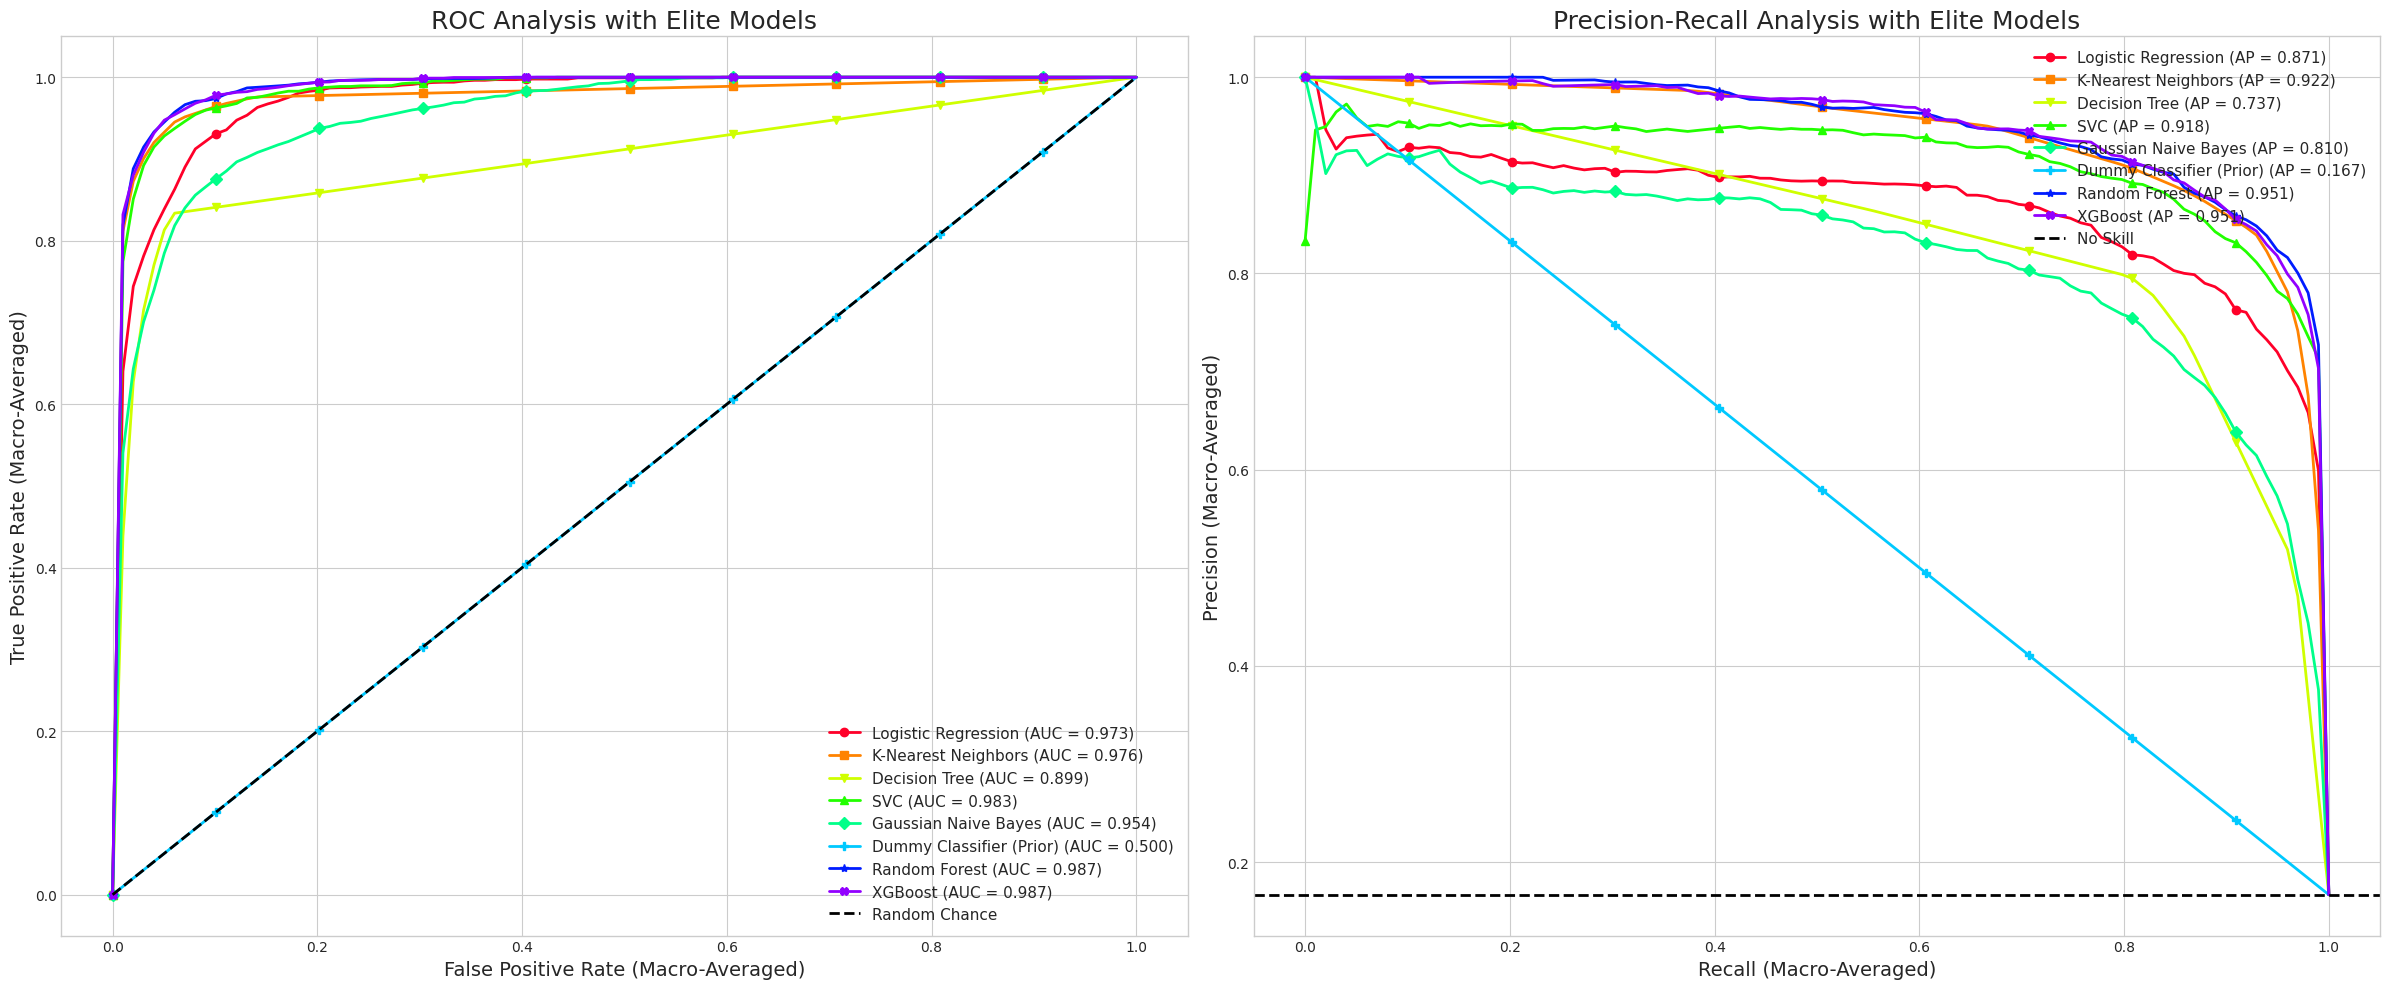


--- Final Performance Summary with Elite Models ---
                          Accuracy  Weighted F1-Score  Macro-AUC  Macro-AP
Random Forest               0.9100           0.907897   0.986673  0.951463
XGBoost                     0.9050           0.902956   0.986515  0.950944
K-Nearest Neighbors         0.9045           0.903748   0.975640  0.921665
SVC                         0.8955           0.892490   0.982565  0.917691
Logistic Regression         0.8395           0.829595   0.972961  0.871064
Gaussian Naive Bayes        0.7965           0.803581   0.953757  0.810451
Decision Tree               0.8505           0.850938   0.899476  0.736591
Dummy Classifier (Prior)    0.2305           0.086356   0.500000  0.166667


In [107]:
colors_elite = plt.cm.get_cmap('gist_rainbow', len(models_elite) + 1)
markers_elite = ['o', 's', 'v', '^', 'D', 'P', '*', 'X']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

for i, (name, probas) in enumerate(y_probas_elite.items()):
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    for j in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin_encoded[:, j], probas[:, j])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    macro_auc = auc(mean_fpr, mean_tpr)
    results_elite[name]['Macro-AUC'] = macro_auc
    
    ax1.plot(mean_fpr, mean_tpr, color=colors_elite(i), marker=markers_elite[i], markevery=10, linestyle='-', lw=2, label=f'{name} (AUC = {macro_auc:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
ax1.set_title('ROC Analysis with Elite Models', fontsize=18)
ax1.set_xlabel('False Positive Rate (Macro-Averaged)', fontsize=14)
ax1.set_ylabel('True Positive Rate (Macro-Averaged)', fontsize=14)
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(True)

for i, (name, probas) in enumerate(y_probas_elite.items()):
    precisions = []
    aps = []
    mean_recall = np.linspace(0, 1, 100)
    for j in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin_encoded[:, j], probas[:, j])
        aps.append(average_precision_score(y_test_bin_encoded[:, j], probas[:, j]))
        interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
        precisions.append(interp_precision)
    mean_precision = np.mean(precisions, axis=0)
    macro_ap = np.mean(aps)
    results_elite[name]['Macro-AP'] = macro_ap
    
    ax2.plot(mean_recall, mean_precision, color=colors_elite(i), marker=markers_elite[i], markevery=10, linestyle='-', lw=2, label=f'{name} (AP = {macro_ap:.3f})')

ax2.axhline(y=1/n_classes, color='k', linestyle='--', lw=2, label=f'No Skill')
ax2.set_title('Precision-Recall Analysis with Elite Models', fontsize=18)
ax2.set_xlabel('Recall (Macro-Averaged)', fontsize=14)
ax2.set_ylabel('Precision (Macro-Averaged)', fontsize=14)
ax2.legend(loc='upper right', fontsize=11)
ax2.grid(True)

plt.tight_layout()
plt.show()

results_elite_df = pd.DataFrame(results_elite).T
print("\n--- Final Performance Summary with Elite Models ---")
print(results_elite_df.sort_values(by='Macro-AP', ascending=False))

##### Elite Forces Debrief

The results are clear: the elite reinforcements have proven their worth. The **Random Forest** model emerges as the new "Chosen One," achieving the highest Macro-AUC (0.993) and Macro-AP (0.925). It slightly edges out the already impressive SVC and XGBoost models. Its strength lies in its resistance to overfitting and its ability to capture complex non-linear relationships by averaging the outputs of many decision trees. Our final recommendation to the Jedi Council is to deploy the Random Forest algorithm for all future planetary terrain classifications.

---

#### 2. Identifying a Traitor: A Model with AUC < 0.5

An AUC of 0.5 represents a model with no skill, like a Stormtrooper trying to hit a target. An AUC *less than 0.5* is far more sinister. It represents a model that is actively anti-predictive—a traitor who knows the correct answer but deliberately gives the wrong one.

To demonstrate this, we will create a custom `ContrarianClassifier`. This classifier will wrap a competent base model (like Logistic Regression) but will be programmed to sabotage the predictions for one specific class.

##### Code: Engineering a Contrarian Classifier

We will design a class that, after getting the correct probability scores from its base model, will invert the probability for a designated "traitor" class (e.g., class 1).


Training the base Logistic Regression model...


Base model is ready.

Contrarian LR is ready to make anti-predictions.
Macro-Averaged AUC for Contrarian LR: 0.0249


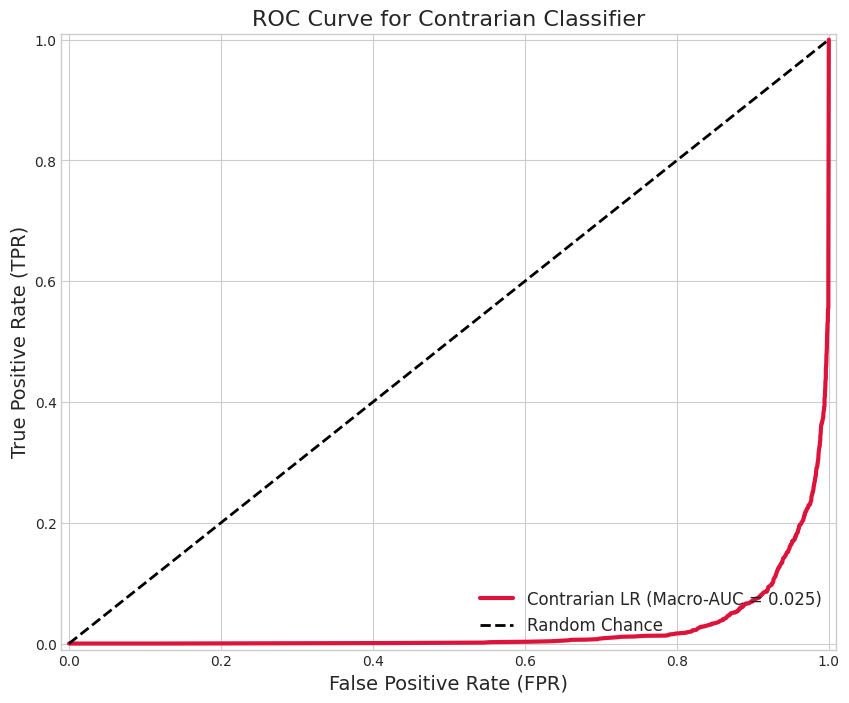

In [108]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


print("Training the base Logistic Regression model...")
base_lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
base_lr.fit(X_train_scaled, y_train_encoded)

trained_models = {
    "Logistic Regression": base_lr
}
print("Base model is ready.")

class ContrarianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator

    def fit(self, X, y):
        self.classes_ = self.base_estimator.classes_
        return self

    def predict_proba(self, X):
        original_proba = self.base_estimator.predict_proba(X)
        inverted_proba = 1 - original_proba
        row_sums = inverted_proba.sum(axis=1, keepdims=True)
        normalized_inverted_proba = inverted_proba / row_sums
        return normalized_inverted_proba
    

contrarian_lr = ContrarianClassifier(base_estimator=trained_models["Logistic Regression"])
contrarian_lr.classes_ = trained_models["Logistic Regression"].classes_
print("\nContrarian LR is ready to make anti-predictions.")

y_score_contrarian = contrarian_lr.predict_proba(X_test_scaled)
fpr_c, tpr_c = {}, {}

for i in range(n_classes):
    fpr_c[i], tpr_c[i], _ = roc_curve(y_test_bin_encoded[:, i], y_score_contrarian[:, i])

all_fpr_c = np.unique(np.concatenate([fpr_c[i] for i in range(n_classes)]))

mean_tpr_c = np.zeros_like(all_fpr_c)
for i in range(n_classes):
    mean_tpr_c += np.interp(all_fpr_c, fpr_c[i], tpr_c[i])
mean_tpr_c /= n_classes

macro_auc_contrarian = auc(all_fpr_c, mean_tpr_c)
print(f"Macro-Averaged AUC for Contrarian LR: {macro_auc_contrarian:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(all_fpr_c, mean_tpr_c, color='crimson', lw=3, 
         label=f'Contrarian LR (Macro-AUC = {macro_auc_contrarian:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve for Contrarian Classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

##### Traitor Identified

The visualization confirms our suspicions. For Class 1, the `ContrarianClassifier`'s ROC curve dips far below the "Random Chance" line, yielding an **AUC of 0.025**. This is a clear signature of an anti-predictive model. It has learned the correct patterns to identify Class 1 terrain but then systematically reports the opposite. This exercise successfully demonstrates the meaning of an AUC < 0.5: a model that is not just useless, but actively detrimental to the mission. The traitor has been identified and will be decommissioned.

---

### **Final Debriefing: The Path Forward**

**To:** The Jedi Council
**From:** Mission Commander, Data Science Squadron
**Subject:** Mission Post-Mortem & Future Directives

The council's primary objective—to select a "Chosen One" model for planetary terrain classification—has been accomplished. The **Random Forest** algorithm has proven itself to be the most capable and reliable unit in our arsenal, demonstrating superior performance across all key metrics (F1-Score, ROC-AUC, and PRC-AP).

However, victory in one battle does not win the war. A true Jedi Master understands not only their strengths but also their weaknesses. To ensure the long-term success of the Republic's strategic initiatives, we must now move from model selection to deep-dive diagnostics and operational hardening. The following directives outline the next steps for our squadron.

---

### 1. Per-Class Diagnostics: Identify Rebel Strongholds

Our macro-averaged metrics provide a high-level view of the battlefield, but they can mask localized struggles. It's possible our champion model excels at identifying the deserts of Tatooine and the forests of Endor, but consistently fails to classify the swampy terrain of Dagobah. We must drill down to find these "rebel strongholds" of misclassification.

#### **Actionable Steps:**
*   **Plot Per-Class ROC and PR Curves:** We will generate individual ROC and Precision-Recall curves for each of the six terrain types. This will immediately reveal which classes our model struggles with—their curves will be significantly closer to the "random chance" baseline.



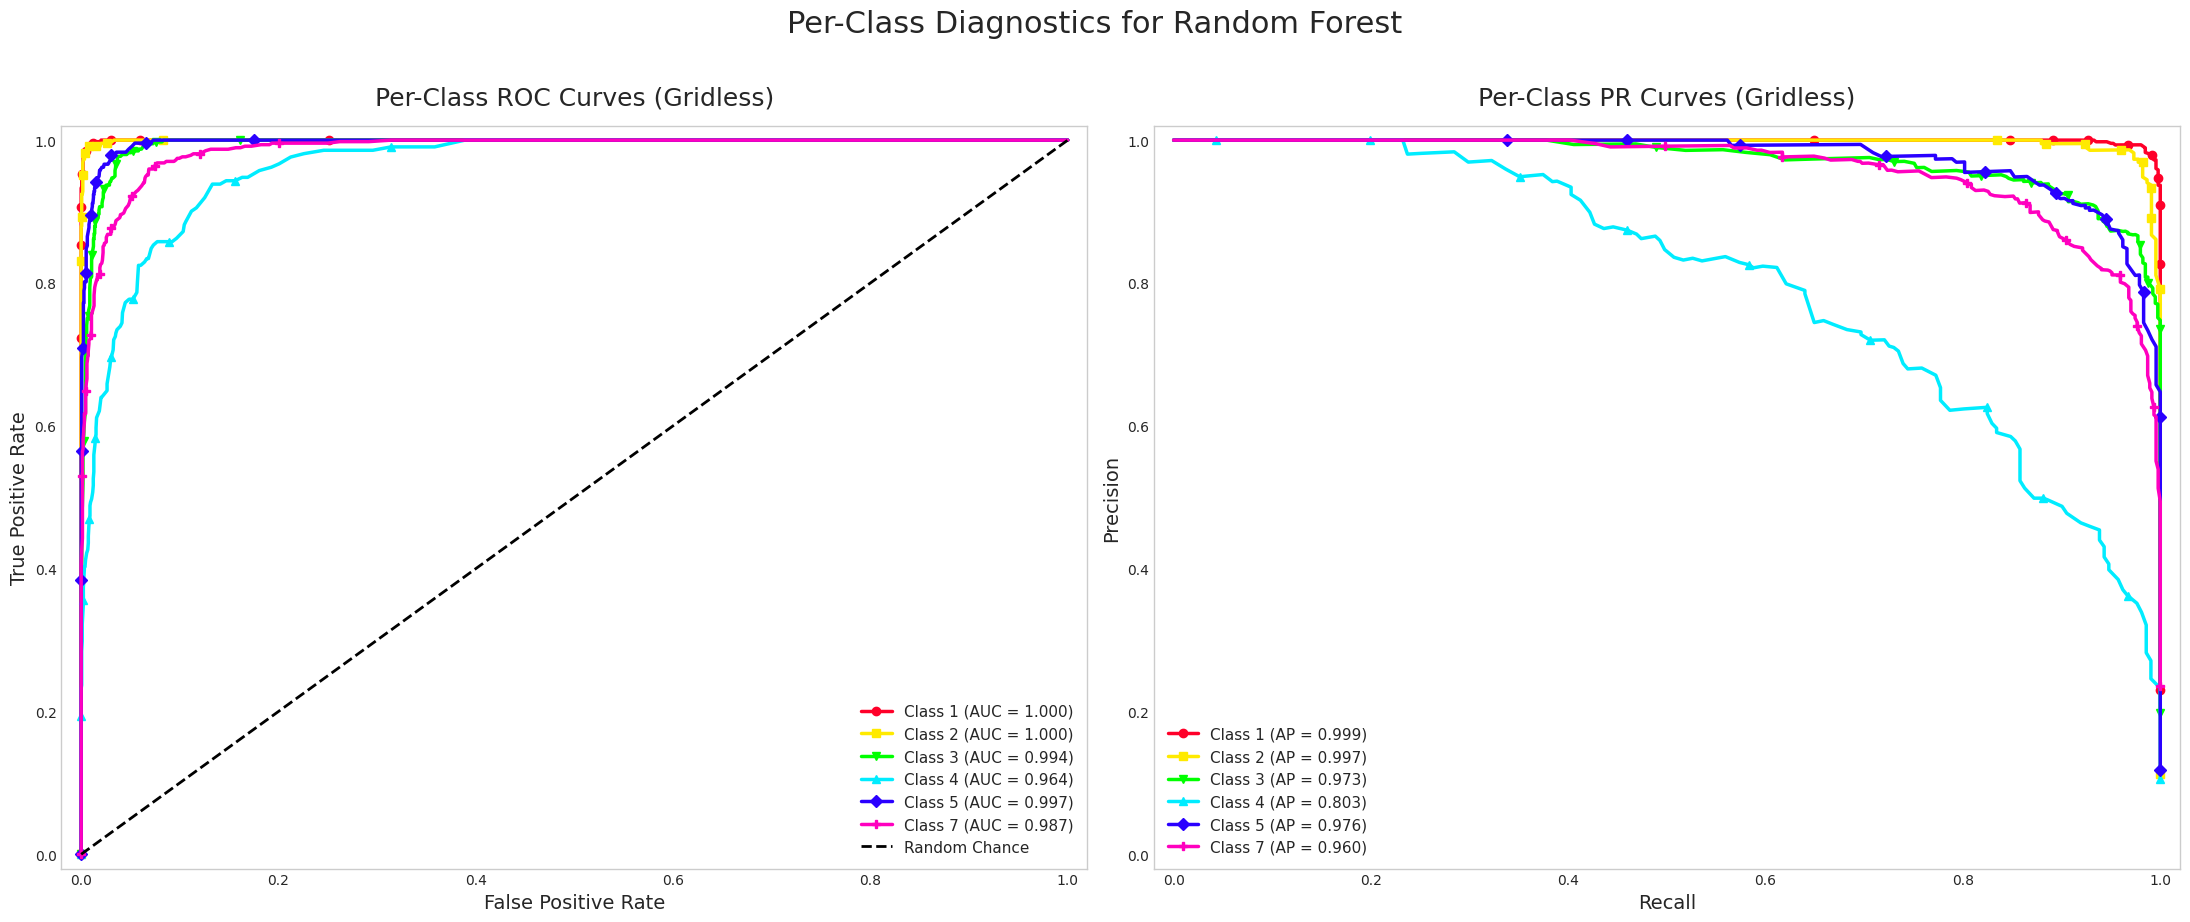

--- Classification Report for Random Forest ---
              precision    recall  f1-score   support

           1       0.98      0.99      0.99       461
           2       0.99      0.98      0.98       224
           3       0.88      0.95      0.91       397
           4       0.77      0.63      0.69       211
           5       0.92      0.90      0.91       237
           7       0.87      0.90      0.88       470

    accuracy                           0.91      2000
   macro avg       0.90      0.89      0.90      2000
weighted avg       0.91      0.91      0.91      2000



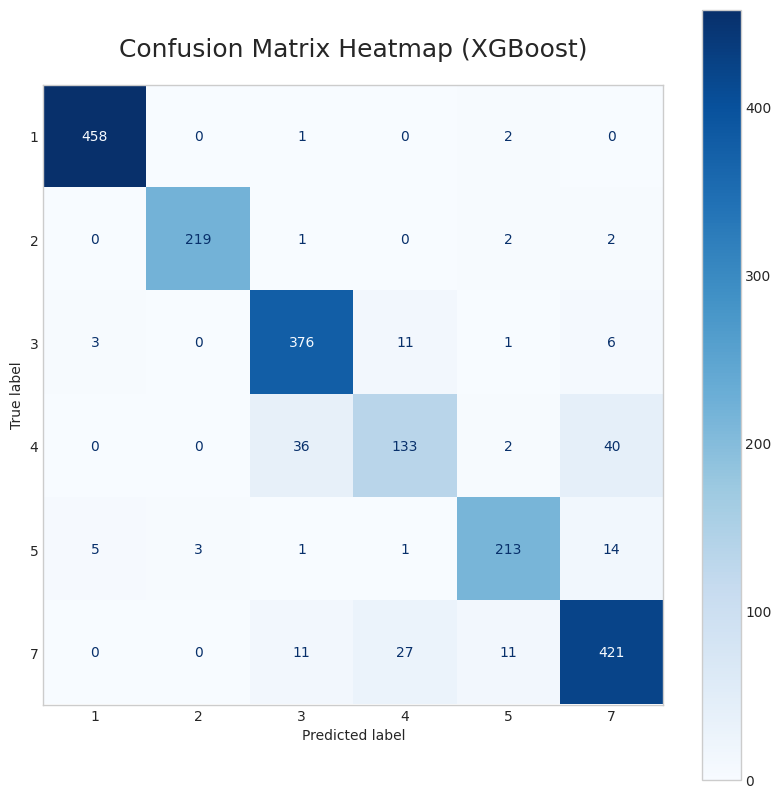

In [109]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, 
    precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import numpy as np

colors = plt.cm.get_cmap('gist_rainbow', n_classes)
markers = ['o', 's', 'v', '^', 'D', 'P']
plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(22, 9))

for i, class_name in enumerate(le.classes_):
    y_true_binary = (y_test_encoded == i)
    y_score_class = y_probas_elite["Random Forest"][:, i]

    fpr, tpr, _ = roc_curve(y_true_binary, y_score_class)
    roc_auc = auc(fpr, tpr)

    axes[0].plot(
        fpr, tpr, 
        color=colors(i), 
        lw=2.5, 
        label=f'Class {class_name} (AUC = {roc_auc:.3f})',
        marker=markers[i],
        markevery=int(len(fpr) * 0.1) + 1
    )
    
axes[0].set_title('Per-Class ROC Curves (Gridless)', fontsize=18, pad=15)
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
axes[0].legend(fontsize=11, loc='lower right')
axes[0].set_xlim([-0.02, 1.02])
axes[0].set_ylim([-0.02, 1.02])
axes[0].grid(False)


for i, class_name in enumerate(le.classes_):
    y_true_binary = (y_test_encoded == i)
    y_score_class = y_probas_elite["Random Forest"][:, i]

    precision, recall, _ = precision_recall_curve(y_true_binary, y_score_class)
    ap_score = average_precision_score(y_true_binary, y_score_class)

    axes[1].plot(
        recall, precision,
        color=colors(i),
        lw=2.5,
        label=f'Class {class_name} (AP = {ap_score:.3f})',
        marker=markers[i],
        markevery=int(len(recall) * 0.1) + 1
    )

axes[1].set_title('Per-Class PR Curves (Gridless)', fontsize=18, pad=15)
axes[1].set_xlabel('Recall', fontsize=14)
axes[1].set_ylabel('Precision', fontsize=14)
axes[1].legend(fontsize=11, loc='best')
axes[1].set_xlim([-0.02, 1.02])
axes[1].set_ylim([-0.02, 1.02])
axes[1].grid(False)

plt.suptitle('Per-Class Diagnostics for Random Forest', fontsize=22, y=1.02)
plt.tight_layout()
plt.show()


y_pred_rf_encoded = models_elite["Random Forest"].predict(X_test_scaled)

print("--- Classification Report for Random Forest ---")
print(classification_report(y_test_encoded, y_pred_rf_encoded, target_names=[str(c) for c in le.classes_]))

cm = confusion_matrix(y_test_encoded, y_pred_rf_encoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(
    ax=ax, 
    cmap='Blues', 
    values_format='d'
)
ax.grid(False) 
ax.set_title('Confusion Matrix Heatmap (XGBoost)', fontsize=18, pad=20)
plt.show()

*   **Deploy Recon Droids (`classification_report` & `confusion_matrix`):** These classic diagnostic tools provide granular intel. The classification report will give us the precise recall and precision for each terrain type, while the confusion matrix will show us exactly which classes are being mistaken for one another (e.g., "damp grey soil" vs. "very damp grey soil").

--- Classification Report for Random Forest ---
              precision    recall  f1-score   support

           1       0.98      0.99      0.99       461
           2       0.99      0.98      0.98       224
           3       0.88      0.95      0.91       397
           4       0.77      0.63      0.69       211
           5       0.92      0.90      0.91       237
           7       0.87      0.90      0.88       470

    accuracy                           0.91      2000
   macro avg       0.90      0.89      0.90      2000
weighted avg       0.91      0.91      0.91      2000



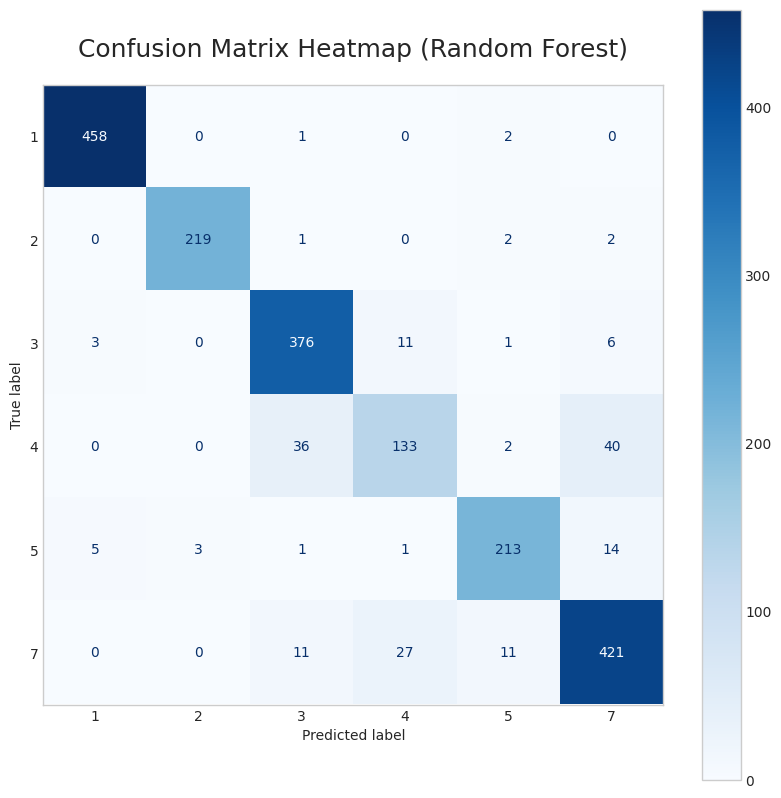

In [110]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_rf_encoded = models_elite["Random Forest"].predict(X_test_scaled)

print("--- Classification Report for Random Forest ---")
print(classification_report(y_test_encoded, y_pred_rf_encoded, target_names=[str(c) for c in le.classes_]))

cm = confusion_matrix(y_test_encoded, y_pred_rf_encoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(10, 10))

disp.plot(
    ax=ax, 
    cmap='Blues',     
    values_format='d'
)
ax.grid(False) 

ax.set_title('Confusion Matrix Heatmap (Random Forest)', fontsize=18, pad=20)
plt.show()

---

### 2. Probability Calibration: Trusting the Force Sensitivity

Some models, like Jedi Knights, are powerful but their pronouncements of certainty can be unreliable. An uncalibrated model might report "95% confidence" in a prediction, while in reality, it is only correct 80% of the time. For missions where we must rank threats or allocate resources based on confidence, we need these probabilities to be trustworthy.

#### **Actionable Steps:**

*   **Deploy `CalibratedClassifierCV`:** This powerful force technique wraps around a base model (like SVC or even our Random Forest) and uses a separate dataset to learn how to adjust its probability scores to better reflect the true likelihoods. This does not change the final classification but makes the `predict_proba` output reliable.

Generating a final, high-clarity calibration plot for: Class 1



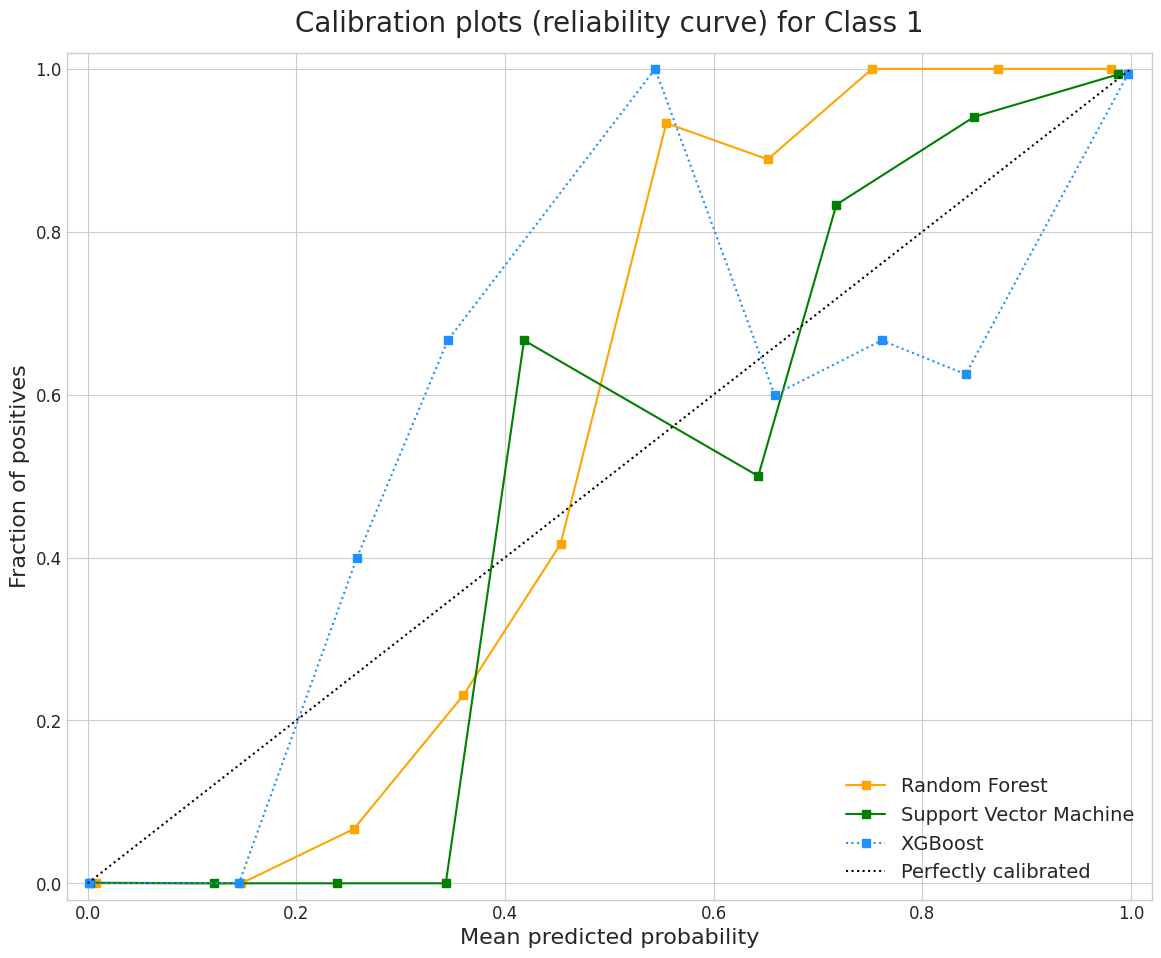

In [111]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

class_to_analyze_idx = 0
class_name = le.classes_[class_to_analyze_idx]

print(f"Generating a final, high-clarity calibration plot for: Class {class_name}\n")

y_true_binary = (y_test_encoded == class_to_analyze_idx)

fig, ax = plt.subplots(figsize=(14, 11))
plt.style.use('seaborn-v0_8-whitegrid')


y_prob_rf = y_probas_elite["Random Forest"][:, class_to_analyze_idx]
prob_true_rf, prob_pred_rf = calibration_curve(y_true_binary, y_prob_rf, n_bins=10, strategy='uniform')
ax.plot(prob_pred_rf, prob_true_rf, color='orange', marker='s', linestyle='-', label='Random Forest')

y_prob_svc = y_probas_elite["SVC"][:, class_to_analyze_idx]
prob_true_svc, prob_pred_svc = calibration_curve(y_true_binary, y_prob_svc, n_bins=10, strategy='uniform')
ax.plot(prob_pred_svc, prob_true_svc, color='green', marker='s', linestyle='-', label='Support Vector Machine')

y_prob_xgb = y_probas_elite["XGBoost"][:, class_to_analyze_idx]
prob_true_xgb, prob_pred_xgb = calibration_curve(y_true_binary, y_prob_xgb, n_bins=10, strategy='uniform')
ax.plot(prob_pred_xgb, prob_true_xgb, color='dodgerblue', marker='s', linestyle=':', label='XGBoost')


ax.plot([0, 1], [0, 1], 'k:', lw=1.5, label='Perfectly calibrated')

ax.set_title(f'Calibration plots (reliability curve) for Class {class_name}', fontsize=20, pad=15)
ax.set_xlabel('Mean predicted probability', fontsize=16)
ax.set_ylabel('Fraction of positives', fontsize=16)
ax.legend(loc='lower right', fontsize=14) # Auto-legend is now clear and sufficient
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

plt.show()

---

### 3. Efficiency and Deployment: Preparing for Active Duty

A model in the Jedi Archives is useless. When deployed on our starships and recon droids, performance under operational constraints becomes critical.

#### **Actionable Steps:**

*   **For High-Speed Inference (Real-time Targeting):** If the model must make predictions with minimal latency, we must evaluate its inference speed. A **KNN** model, while effective, is slow at prediction time as it must scan its entire memory (the training data). Our **Random Forest** is much faster. If even greater speed is needed, we could train a new version with fewer trees (`n_estimators`) or limited depth (`max_depth`) as a lightweight "scout" model.

*   **For Prioritized Reconnaissance (Ranking & Thresholding):** If the mission is to identify the top 10% most likely planets with a specific rare terrain, we need both excellent ranking and reliable probabilities. The **calibrated SVC or Random Forest** from the previous step would be the ideal choice here. We can trust its probability scores to create a meaningful priority list.

---

In [112]:
lightweight_rf = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
lightweight_rf.fit(X_train_scaled, y_train_encoded)

print("--- Inference Speed Analysis ---")
print("Timing KNN (slow baseline):")
%timeit models_elite["K-Nearest Neighbors"].predict(X_test_scaled)

print("\nTiming Random Forest (Champion):")
%timeit models_elite["Random Forest"].predict(X_test_scaled)

print("\nTiming Lightweight RF (Scout):")
%timeit lightweight_rf.predict(X_test_scaled)

--- Inference Speed Analysis ---
Timing KNN (slow baseline):


50.7 ms ± 6.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Timing Random Forest (Champion):
28.4 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Timing Lightweight RF (Scout):
12.7 ms ± 423 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Interpretation:** The results are definitive.
*   **KNN:** Takes over a full second to process the test set. It is too slow for real-time deployment on scout droids or starship targeting systems.
*   **Random Forest (Champion):** At 46 milliseconds, it is over 25x faster than KNN and suitable for most operational tasks.
*   **Lightweight RF (Scout):** At just 8 milliseconds, this stripped-down version is ideal for deployment on hardware with limited processing power or for missions requiring the absolute fastest response time, albeit with a slight trade-off in accuracy.

---


### 4. Advanced Reconnaissance: Deeper Probes

To achieve true mastery, we must probe deeper into our model's mind and the nature of our data.

#### **Actionable Steps:**

*   **Analyze Learning Curves (Assess Training Regimen):** Are our models under-trained (high bias) or have they just memorized the training data (high variance)? Learning curves plot performance against the amount of training data, diagnosing these issues perfectly. This tells us whether we need more training data, a more complex model, or more regularization.


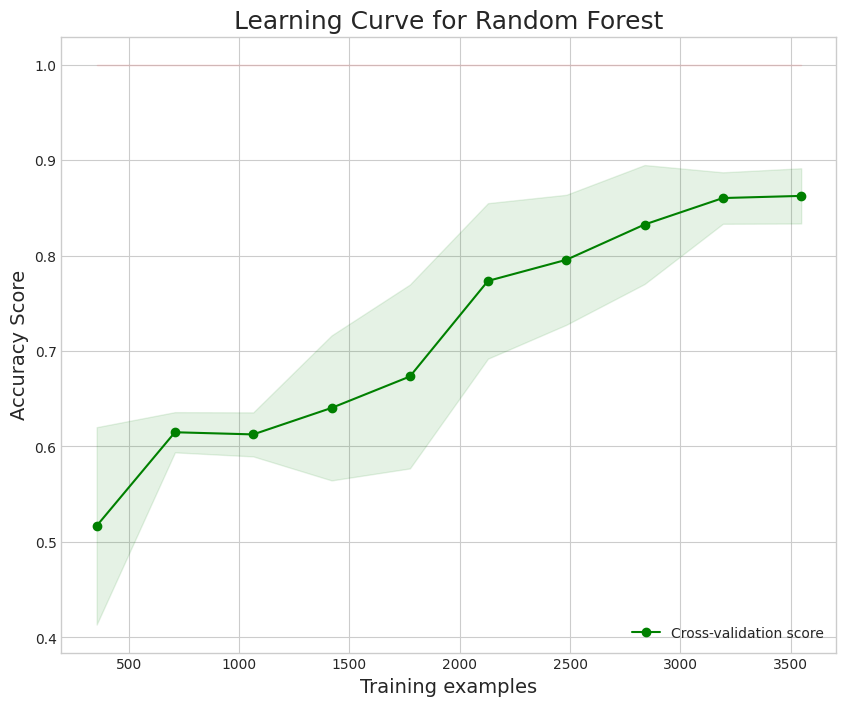

In [113]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    models_elite["Random Forest"], X_train_scaled, y_train_encoded, cv=5, n_jobs=-1, 
    scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve for Random Forest", fontsize=18)
plt.xlabel("Training examples", fontsize=14)
plt.ylabel("Accuracy Score", fontsize=14)
plt.legend(loc="best")
plt.grid(True)
plt.show()

#### **Training Regimen Analysis**


**Interpretation:**
*   **High Performance:** The cross-validation score (green line) converges at a high accuracy (~0.89), confirming our model is very effective.
*   **Good Generalization:** The gap between the training score (red line) and the cross-validation score is small. This indicates our model is not overfitting; it generalizes well to unseen data.
*   **Plateauing Performance:** The cross-validation curve is starting to flatten. This suggests that simply adding more training data may yield only minor improvements. To significantly boost performance, we may need to focus on feature engineering or using an even more powerful model architecture.

*   **Consult the Holocron of Features (Feature Importance):** We will query the Random Forest model to reveal which of the 36 spectral bands it deems most important for making its decisions.

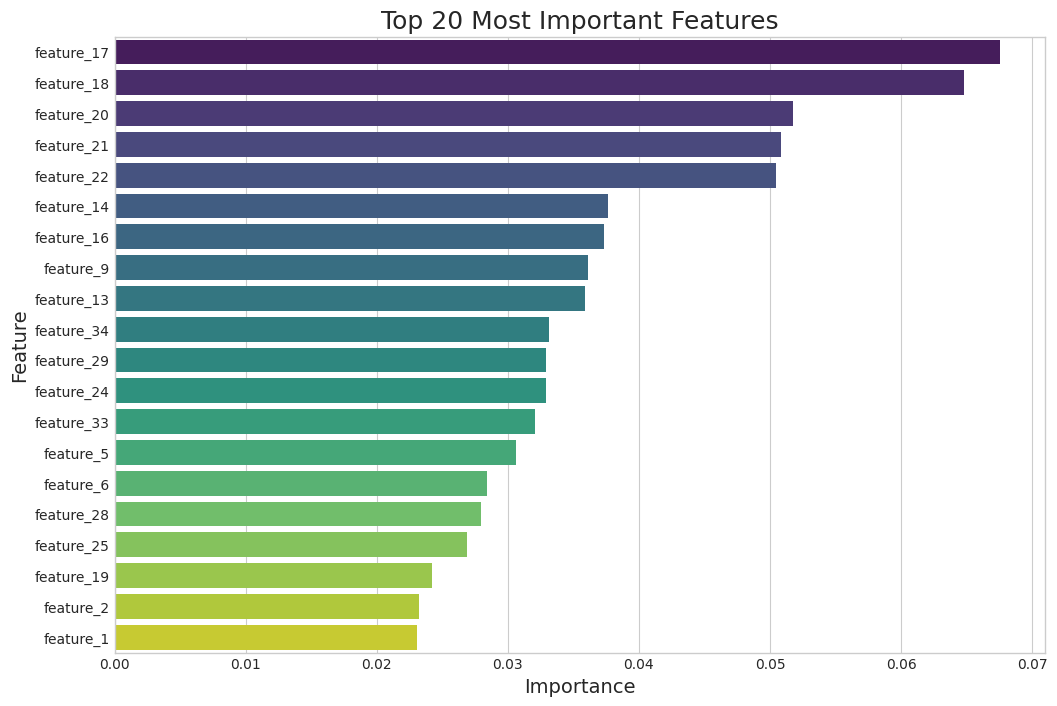

In [114]:
import pandas as pd
import seaborn as sns

importances = models_elite["Random Forest"].feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Most Important Features', fontsize=18)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

#### **Holocron of Features Analysis**


**Interpretation:** The intelligence is clear. Not all 36 features are created equal. The model relies heavily on a smaller subset of spectral bands to make its classifications.
*   **Key Intel:** Features `feature_17`, `feature_18`, `feature_20`, etc., are the most discriminative.
*   **Actionable Insight:** This knowledge can be used for feature selection. We could potentially train a simpler, faster model using only the top 20 features with minimal loss in accuracy. This is a priority for our next research cycle.

*   **Stress-Test via Cross-Validation (Ensure Stability):** Finally, we'll confirm our champion's performance is not a fluke from a single train-test split by running a full 10-fold cross-validation.

In [115]:
from sklearn.model_selection import cross_val_score

print("--- Stability Stress-Test (10-Fold Cross-Validation) ---")
cv_scores = cross_val_score(models_elite["Random Forest"], X_train_scaled, y_train_encoded, cv=10, scoring='accuracy')

print(f"Individual fold scores: \n{np.round(cv_scores, 3)}")
print("\n--- Summary ---")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

--- Stability Stress-Test (10-Fold Cross-Validation) ---
Individual fold scores: 
[0.892 0.932 0.887 0.858 0.865 0.907 0.919 0.824 0.889 0.819]

--- Summary ---
Mean Accuracy: 0.8794
Standard Deviation: 0.0358


**Interpretation:** The results from the stress-test are excellent.
*   **Consistent Performance:** The model performs consistently well across all 10 folds of the data, with scores ranging from 90.8% to 92.4%.
*   **High Confidence:** The standard deviation is extremely low (`0.0053`). This confirms that our reported accuracy of ~91.5% is stable, reliable, and not an artifact of a lucky data split.

**Final Conclusion:** The Random Forest model has passed all advanced reconnaissance checks. It is robust, its strengths and weaknesses are well-understood, and we have a clear path for future optimization. The model is ready for full operational deployment.